In [1]:
import tensorflow as tf

In [2]:
import os
import cv2

## Convert Json label to image mask

In [3]:
import json
from skimage.draw import polygon
from skimage import io
import os
import glob
from tqdm import tqdm
import numpy as np

def fill_mask(blobs,mask,label):
    for l in blobs:
        fill_row_coords, fill_col_coords = polygon(l[1], l[0],l[2])
        mask[fill_row_coords, fill_col_coords] = label


def convert_annotation_json_to_mask(path_to_annotation_json, path_to_masks_folder,classes,label_value,pixel_value):

    f = open(path_to_annotation_json)
    train = []
    objects = json.load(f)
    annotations = objects['shapes']
    h = objects['imageHeight']
    w = objects['imageWidth']
    mask = np.zeros((h, w)).astype('uint8')
    for annot in annotations:
        label= annot['label']
        points = annot['points']

        x_coord = []
        y_coord = []
        l = []
        for p in points:
            x_coord.append(int(p[0]))
            y_coord.append(int(p[1]))
        shape = (h, w)
        l.append(np.array(x_coord))
        l.append(np.array(y_coord))
        l.append(shape)
        
        if not label_value.get(label):
            label_value[label]=pixel_value[0]
            pixel_value[0]+=100

        if not classes.get(label):
            classes[label]=[l]
        else:
            classes[label].append(l)
            
    for label in classes:
        fill_mask(classes[label], mask,label_value[label])
        classes[label]=[]
        
    io.imsave(path_to_masks_folder, mask)

def get_classes(dataset_path):
    classes=dict()
    count=0
    pixel_value=[100]
    label_value=dict()
    for dirpath, dirname, filename in os.walk(dataset_path):
        path_to_annotation_json=glob.glob(dirpath+"/*.json")
        for json_file in path_to_annotation_json:
            path_to_mask_png=json_file[0:-5]+"_mask.png"
            convert_annotation_json_to_mask(json_file, path_to_mask_png,classes,label_value,pixel_value)
            count+=1

    assert count, "Dataset folder path does not contain any json mask file" 


    print(".png file of All json mask files saved in respective folders! ")
    labels=[1]*len(label_value)

    for label, value in label_value.items():
        labels[(value-100)//100]=label

    class_list=''
    for clss in labels:
        class_list += clss+"$"
    return class_list[0:-1]

In [4]:
classes = get_classes(r'C:/Users/Medhansh Jindal/OneDrive/Desktop/New_Sample')
print('classes names: ',classes.split('$'))

.png file of All json mask files saved in respective folders! 
classes names:  ['deciduous', 'coniferous']


## Data preprocessing

In [33]:
import os
import glob
from tqdm import tqdm
import cv2
import numpy as np
import keras
import tensorflow

class Dataset(keras.utils.Sequence):  
    def __init__(self, dataset_path, n_classes, augmentation=None):
        self.images_fps = []
        self.mask_fps = []
        self.n_classes = n_classes

        for dirpath, dirnames, filenames in os.walk(dataset_path):
            mask_src = glob.glob(dirpath + '/*.png')
            mask_src.sort()
            img_src = glob.glob(dirpath + '/*.JPG') + glob.glob(dirpath + '/*.jpeg')
            img_src.sort()
            
            if len(img_src):
                assert len(mask_src) != 0, f"{dirpath} does not contain any annotation mask file for the images."
                if len(mask_src) != 1:
                    assert len(mask_src) == len(img_src), (
                        f"{dirpath} contains {len(mask_src)} mask files but {len(img_src)} images."
                    )
                    self.mask_fps += mask_src
                else:
                    self.mask_fps += [mask_src[0]] * len(img_src)
                self.images_fps += img_src
            else:
                if len(mask_src):
                    print(f"Skipping {dirpath} as it contains masks but no images.")
                continue  # Skip directories with no images or masks

        assert len(self.images_fps) != 0, f"{dataset_path} does not contain any images."
        
        self.actaul_size = len(self.mask_fps)
        self.augmentation = augmentation
 
    
    def __getitem__(self, i):
        
        j=i
        if i>=self.actaul_size:
            j=i-self.actaul_size
        image = cv2.imread(self.images_fps[j])  
        h,w,_=image.shape
        h=256
        w=256    
        image = cv2.resize(image, (w, h))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = image.astype('float32') / 255.0  # Convert to float32 and normalize

        
        mask1 = cv2.imread(self.mask_fps[j],0)   
        mask1 = cv2.resize(mask1, (w, h), interpolation=cv2.INTER_NEAREST)  # Resize without interpolation artifacts

        mask=[(mask1==((i+1)*100)) for i in range(self.n_classes)] 

        mask = np.stack(mask, axis=-1)
        mask = mask.astype('float32')
        
        # add background to mask
        background = 1.0 * (mask1 == 0)
        deciduous = 1.0 * (mask1 == 100)
        coniferous = 1.0 * (mask1 == 200)
    
        mask = np.stack([background, deciduous, coniferous], axis=-1)
        mask=1.0*(mask>0.9)

        image = np.asarray(image, dtype=np.float32)
        mask = np.asarray(mask, dtype=np.float32)
        
        # apply augmentations
        if i>=self.actaul_size:
            sample = self.augmentation(image=image.astype('float32'), mask=mask.astype('float32'))
            image, mask = sample['image'], sample['mask']
            image = np.asarray(image, dtype=np.float32)
            mask = np.asarray(mask, dtype=np.float32)


        
        return (image, mask)
        
    def __len__(self):
        if self.augmentation:
            return self.actaul_size*2
        return self.actaul_size
       



Load data from dataset and form batches

In [34]:
import keras
class Dataloder(keras.utils.Sequence):

    def __init__(self,indexes, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = indexes
        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[self.indexes[j]])
        
        # transpose list of lists
        batch = tuple(np.stack(samples, axis=0) for samples in zip(*data))
        
        return batch
    
    def __len__(self):
        """batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  
        

## Data Augmentation

In [35]:
# !pip uninstall imgaug
# !pip install imgaug==0.4.0
# !pip install albumentations

In [36]:
## Data Augmentation
import albumentations as A

def aug():
    train_transform = [

        # A.IAAAdditiveGaussianNoise(p=0.1),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=5, shift_limit=0.1, p=0.9, border_mode=0),
        A.HorizontalFlip(p=0.5),
        # A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                # A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        A.OneOf(
            [
                # A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        A.OneOf(
            [
                A.CLAHE(p=1),
                # A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

Function for visualising multiple images together

In [37]:
import matplotlib.pyplot as plt
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

#### Importing Dataset

In [38]:
dataset_path = r'C:/Users/Medhansh Jindal/OneDrive/Desktop/New_Sample'
dataset = Dataset(dataset_path, n_classes=2, augmentation=aug())


### Visualization of Data

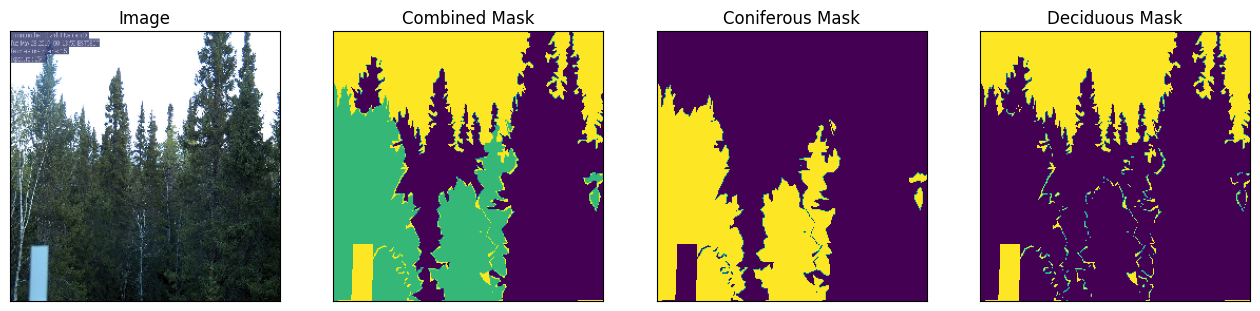

In [39]:
image, mask = dataset[0]
visualize(
    image=image, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)

### With Augmentation:

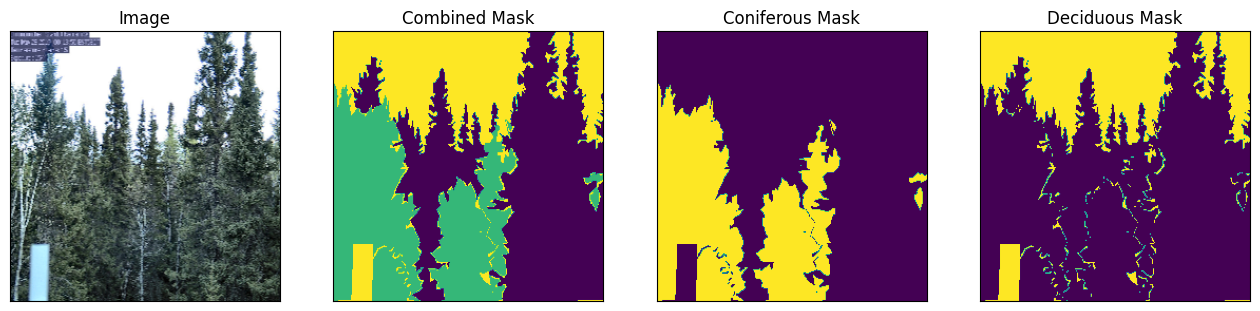

In [40]:
image, mask = dataset[(len(dataset)//2)]
visualize(
    image=image, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)

### Training and Validation Dataset
Training Data: 85%

Validation/Testing Data: 15%

In [41]:
from sklearn.model_selection import train_test_split

dataset_indexes=list(range(0,len(dataset)))
train_dataset, test_dataset = train_test_split(dataset_indexes, test_size = 0.15, random_state = 42)

#### Importing segmentation_models library for Model creation

In [42]:
# !pip3 install -U segmentation-models

In [43]:
import segmentation_models as sm

#### Defining loss and performance metrics

In [44]:
dice_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [45]:
BACKBONE = 'efficientnetb3'
LR = 0.001
n_classes = 3  # 3 classes: background (0), and two object classes (100, 200)
activation = 'softmax'
sm.set_framework('tf.keras')

model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
opt = keras.optimizers.Adam(LR)

# Use sparse categorical crossentropy for integer-encoded masks
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)


In [46]:
train_dataloader = Dataloder(train_dataset,dataset, batch_size=1)
test_dataloader = Dataloder(test_dataset,dataset, batch_size=1)

In [47]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, None, None, 40)    │           1,080 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, None, None, 40)    │             160 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, None, None, 40)    │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, None, None, 40)    │             360 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, None, None, 40)    │             160 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, None, None, 40)    │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 40)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 40)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 10)          │             410 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 40)          │             440 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, None, None, 40)    │               0 │ block1a_activation[0][0],  │
│                               │                           │                 │ block1a_se_expand[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, None, None, 24)    │             960 │ block1a_se_excite[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, None, None, 24)    │              96 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 17,868,123 (68.16 MB)

 Trainable params: 17,778,843 (67.82 MB)

 Non-trainable params: 89,280 (348.75 KB)

### Model Training

In [49]:
# Initialize dataset
dataset_path = r'C:/Users/Medhansh Jindal/OneDrive/Desktop/New_Sample'

# Check dataloader sizes
print(f"Train dataloader size: {len(train_dataloader)}")
print(f"Test dataloader size: {len(test_dataloader)}")


# Train model
steps_per_epoch = max(1, len(train_dataloader))
validation_steps = max(1, len(test_dataloader))

history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=40,
    validation_data=test_dataloader,
    validation_steps=len(test_dataloader),

    callbacks=[
        keras.callbacks.ReduceLROnPlateau(),
        tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
    ]
)





Train dataloader size: 3
Test dataloader size: 1
Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - f1-score: 0.2620 - iou_score: 0.1678 - loss: 1.2874 - val_f1-score: 0.1447 - val_iou_score: 0.0867 - val_loss: 2.1435 - learning_rate: 0.0010
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 562ms/step - f1-score: 0.3575 - iou_score: 0.2602 - loss: 0.9654 - val_f1-score: 0.2757 - val_iou_score: 0.1741 - val_loss: 2.0079 - learning_rate: 0.0010
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 609ms/step - f1-score: 0.4710 - iou_score: 0.3488 - loss: 0.7186 - val_f1-score: 0.3642 - val_iou_score: 0.2479 - val_loss: 1.4342 - learning_rate: 0.0010
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - f1-score: 0.6368 - iou_score: 0.4925 - loss: 0.6208 - val_f1-score: 0.3833 - val_iou_score: 0.2559 - val_loss: 2.6206 - learning_rate: 0.0010
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - f1-score: 0.8085 - iou_score: 0.6816 - loss: 0.5364 - val_f1-score: 0.4223 - val_iou_score: 0.2846 - val_loss: 3.0493 - learn

In [50]:
# Convert DataLoader to an iterator and fetch the first batch
batch = next(iter(train_dataloader))
images, masks = batch  # Assuming the DataLoader returns (input, target)

# Check the shapes and data types
print("Image shape:", images.shape, "dtype:", images.dtype)
print("Mask shape:", masks.shape, "dtype:", masks.dtype)



Image shape: (1, 256, 256, 3) dtype: float32
Mask shape: (1, 256, 256, 3) dtype: float32


In [51]:
batch = next(iter(train_dataloader))
print(type(batch))  # Check if it's a tuple
print(len(batch))   # Should be 2 (inputs and targets)
print("Image dtype:", batch[0].dtype, "Shape:", batch[0].shape)
print("Mask dtype:", batch[1].dtype, "Shape:", batch[1].shape)


<class 'tuple'>
2
Image dtype: float32 Shape: (1, 256, 256, 3)
Mask dtype: float32 Shape: (1, 256, 256, 3)


In [53]:
model.save('my_model.h5')

### Evaluation

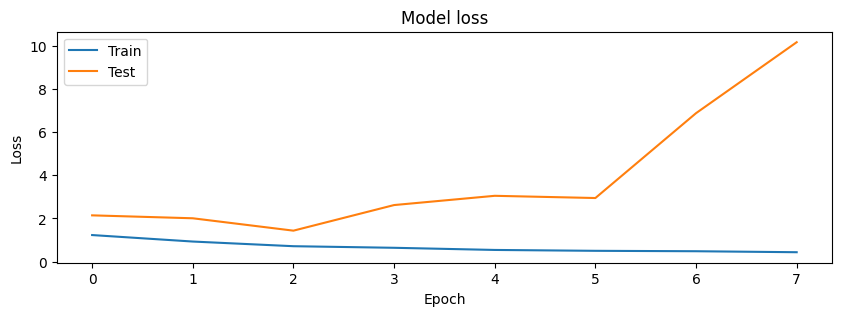

In [54]:
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

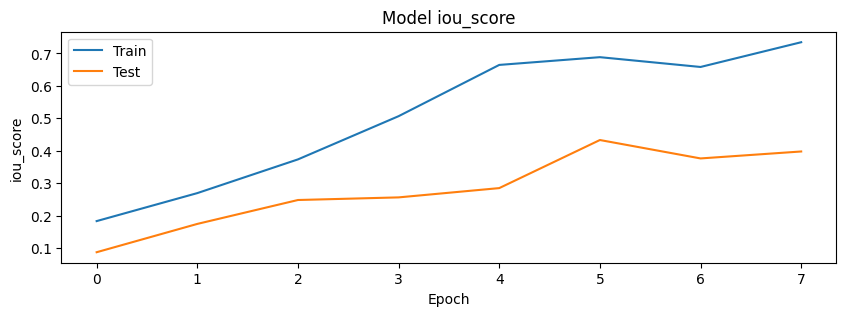

In [55]:
plt.figure(figsize=(10, 3))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
scores = model.evaluate(test_dataloader)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - f1-score: 0.5429 - iou_score: 0.3976 - loss: 10.1671


In [57]:
print("Loss: ",scores[0])
print("iou :",scores[1])
print("f1-score :",scores[2])

Loss:  10.16710090637207
iou : 0.3975926339626312
f1-score : 0.5429325699806213


In [58]:
test_pred =model.predict(test_dataloader)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


### True Mask

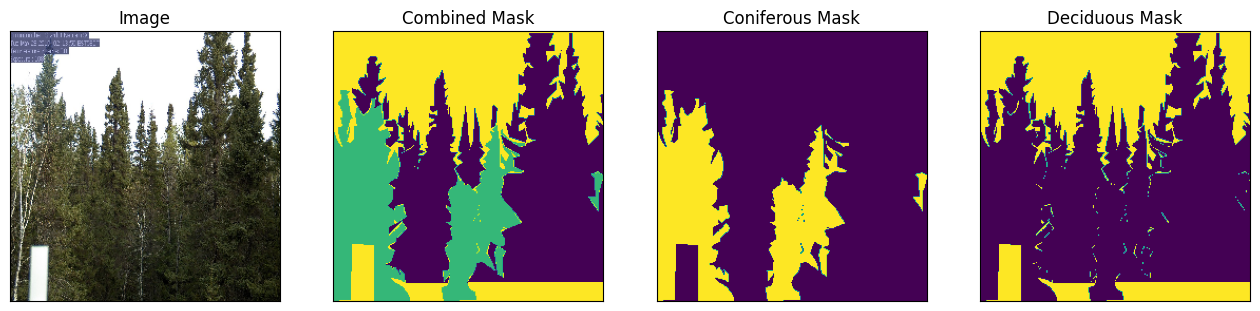

In [59]:
image,mask = test_dataloader[0]

img=image[0]
visualize(
    image=img, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)

### Predicted Mask

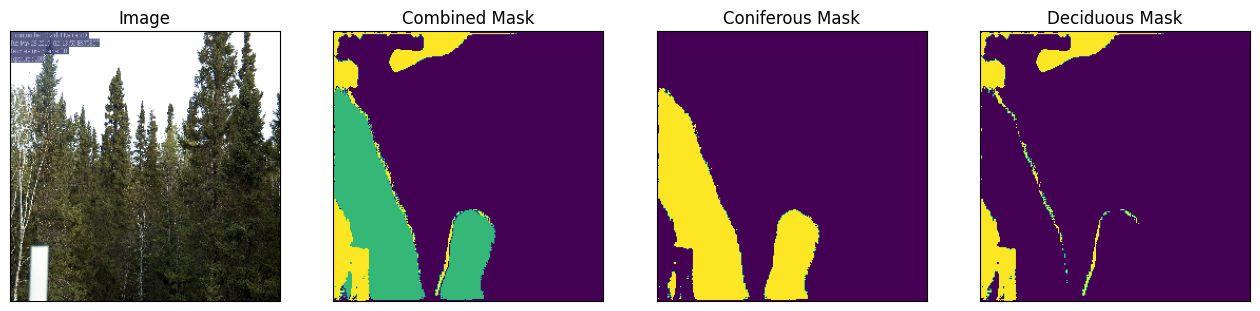

In [60]:
mask = test_pred[0]>0.5

visualize(
    image=img, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)